In [ ]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Mengunggah file kaggle.json
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/leukemia-classification --force

 98% 847M/867M [00:09<00:00, 43.0MB/s]
100% 867M/867M [00:09<00:00, 99.7MB/s]


In [ ]:
!unzip leukemia-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_5_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_6_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_12_7_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_1_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_2_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_13_3_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_1_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_2_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_3_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_4_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_5_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/all/UID_25_14_6_all.bmp  
  inflating: C-NMC_Leukemia/training_data/fold_2/

In [ ]:
DATASET_PATH = "/content/C-NMC_Leukemia"
TRAINING_PATH = os.path.join(DATASET_PATH, 'training_data')

# Path untuk folder0
TRAINING_ALL_PATH_0 = os.path.join(TRAINING_PATH, 'fold_0', 'all')
TRAINING_HEM_PATH_0 = os.path.join(TRAINING_PATH, 'fold_0', 'hem')

# Path untuk folder1
TRAINING_ALL_PATH_1 = os.path.join(TRAINING_PATH, 'fold_1', 'all')
TRAINING_HEM_PATH_1 = os.path.join(TRAINING_PATH, 'fold_1', 'hem')

# Path untuk folder2
TRAINING_ALL_PATH_2 = os.path.join(TRAINING_PATH, 'fold_2', 'all')
TRAINING_HEM_PATH_2 = os.path.join(TRAINING_PATH, 'fold_2', 'hem')

# Path untuk folder validasi
VALIDATION_PATH = os.path.join(DATASET_PATH, 'validation_data', 'C-NMC_test_prelim_phase_data')

# Path untuk folder pengujian
TEST_PATH = os.path.join(DATASET_PATH, 'testing_data', 'C-NMC_test_final_phase_data')


LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/models/vgg16"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [ ]:
def set_seed ():
  '''
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def load_training_set (image_height, image_width, batch_size):
  '''
  load_training_set loads the training set from the "training_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the training set
  '''
  return image_dataset_from_directory(
    os.path.join(TRAINING_PATH, 'fold_0'),
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True,
    seed = 123,
  )

def load_validation_set (image_height, image_width, batch_size):
  '''
  load_validation_set loads the validation set from the "validation_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the validation set
  '''
  return image_dataset_from_directory(
    os.path.join(DATASET_PATH, 'validation_data'),
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True,
    seed = 123,
  )

def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the test set
  '''
  return image_dataset_from_directory(
    os.path.join(DATASET_PATH, 'testing_data'),
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True,
    seed = 123,
  )

def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, epochs = 20, patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  show_training_and_validation_performance(history)

def evaluate_model(model):
    '''
    evaluate_model is used to plot some statistics about the performance on the test set
    :param model: model to consider
    '''
    y_score = model.predict(test_dataset)
    y_pred = np.rint(y_score)  # to have 0 or 1
    y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis=0)
    print("Classification report: ")
    print(metrics.classification_report(y_true, y_pred, digits=4))
    metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

In [ ]:
set_seed()

In [ ]:
train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 3527 files belonging to 2 classes.
Found 1867 files belonging to 1 classes.
Found 2586 files belonging to 1 classes.


In [ ]:
conv_base = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),
    alpha=1,
    include_top= False,
    weights="imagenet",
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
conv_base.trainable = False

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                             

Epoch 1/30
111/111 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.7857
Epoch 1: val_loss improved from inf to 2.19757, saving model to /content/models/experiment1_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/111 [==============================] - 29s 152ms/step - loss: 0.8296 - accuracy: 0.7857 - val_loss: 2.1976 - val_accuracy: 0.3990
Epoch 2/30
111/111 [==============================] - ETA: 0s - loss: 0.3747 - accuracy: 0.8665
Epoch 2: val_loss improved from 2.19757 to 0.30458, saving model to /content/models/experiment1_feature_extraction.h5
111/111 [==============================] - 10s 86ms/step - loss: 0.3747 - accuracy: 0.8665 - val_loss: 0.3046 - val_accuracy: 0.8848
Epoch 3/30
111/111 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.9053
Epoch 3: val_loss improved from 0.30458 to 0.09291, saving model to /content/models/experiment1_feature_extraction.h5
111/111 [==============================] - 10s 84ms/step - loss: 0.2529 - accuracy: 0.9053 - val_loss: 0.0929 - val_accuracy: 0.9646
Epoch 4/30
111/111 [==============================] - ETA: 0s - loss: 0.2765 - accuracy: 0.9064
Epoch 4: val_loss did not improve from 0.09291
111/111 [====================

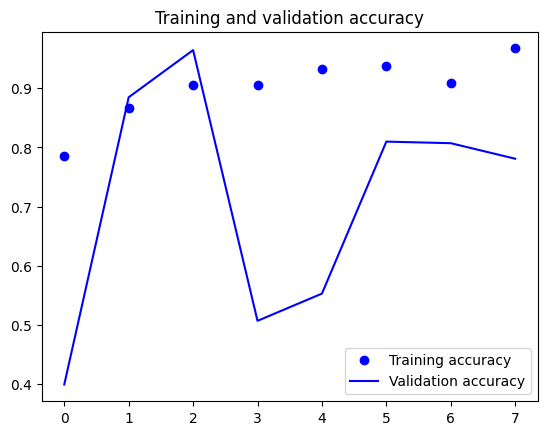

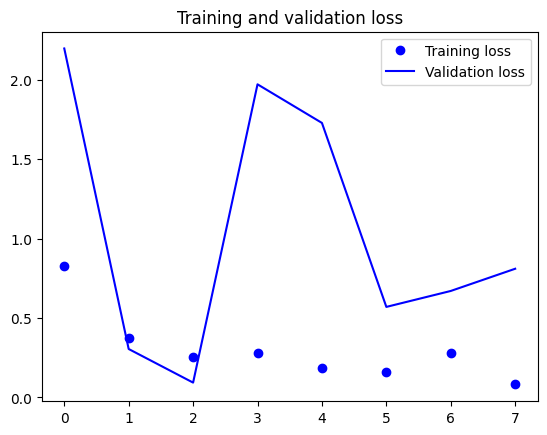

In [ ]:
run_model(model1, 'experiment1_feature_extraction', epochs = 30, patience=5)

81/81 [==============================] - 19s 202ms/step
Classification report: 
              precision    recall  f1-score   support

         0.0     1.0000    0.8183    0.9000      2586
         1.0     0.0000    0.0000    0.0000         0

    accuracy                         0.8183      2586
   macro avg     0.5000    0.4091    0.4500      2586
weighted avg     1.0000    0.8183    0.9000      2586



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


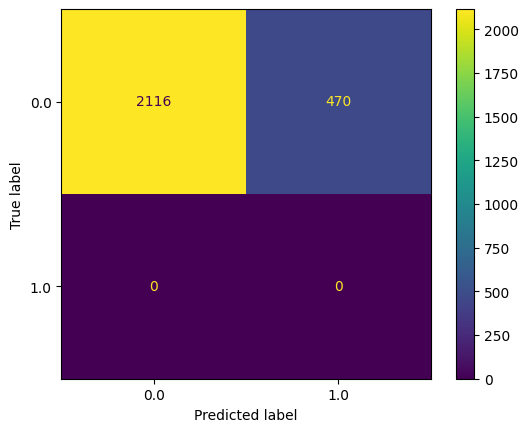

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction.h5'))

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                   

Epoch 1/30
111/111 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.7854
Epoch 1: val_loss improved from inf to 0.77387, saving model to /content/models/experiment2_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/111 [==============================] - 17s 92ms/step - loss: 0.5554 - accuracy: 0.7854 - val_loss: 0.7739 - val_accuracy: 0.6176
Epoch 2/30
110/111 [============================>.] - ETA: 0s - loss: 0.4515 - accuracy: 0.8162
Epoch 2: val_loss improved from 0.77387 to 0.63063, saving model to /content/models/experiment2_feature_extraction.h5
111/111 [==============================] - 9s 81ms/step - loss: 0.4525 - accuracy: 0.8157 - val_loss: 0.6306 - val_accuracy: 0.7102
Epoch 3/30
111/111 [==============================] - ETA: 0s - loss: 0.4123 - accuracy: 0.8268
Epoch 3: val_loss improved from 0.63063 to 0.42280, saving model to /content/models/experiment2_feature_extraction.h5
111/111 [==============================] - 12s 108ms/step - loss: 0.4123 - accuracy: 0.8268 - val_loss: 0.4228 - val_accuracy: 0.8077
Epoch 4/30
110/111 [============================>.] - ETA: 0s - loss: 0.3579 - accuracy: 0.8497
Epoch 4: val_loss improved from 0.42280 to 0.18709, saving model to /content/

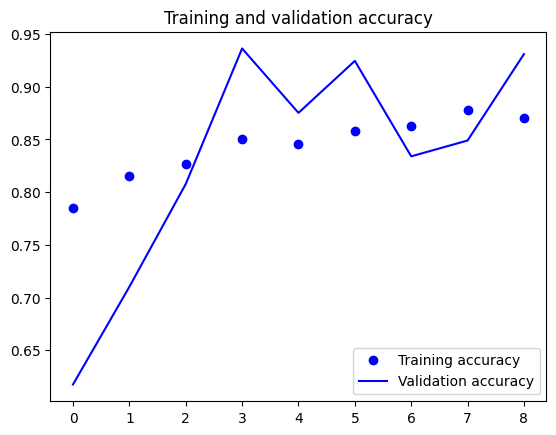

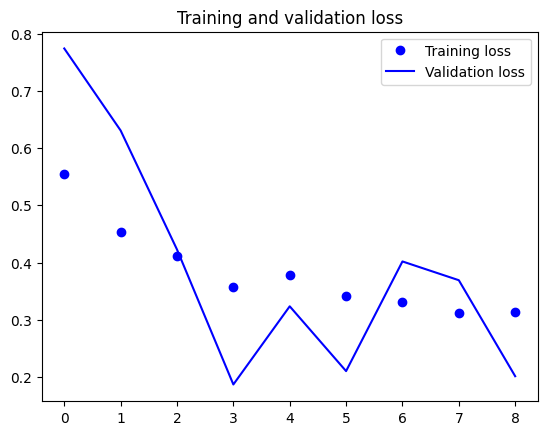

In [ ]:
run_model(model2, 'experiment2_feature_extraction', epochs = 30, patience=5)

81/81 [==============================] - 8s 67ms/step
Classification report: 
              precision    recall  f1-score   support

         0.0     1.0000    0.6628    0.7972      2586
         1.0     0.0000    0.0000    0.0000         0

    accuracy                         0.6628      2586
   macro avg     0.5000    0.3314    0.3986      2586
weighted avg     1.0000    0.6628    0.7972      2586



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


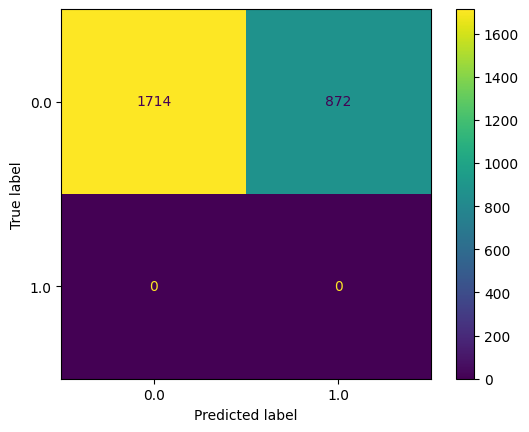

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment2_feature_extraction.h5'))

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

Epoch 1/50
111/111 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.7179
Epoch 1: val_loss improved from inf to 0.21553, saving model to /content/models/experiment3_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/111 [==============================] - 15s 95ms/step - loss: 0.5732 - accuracy: 0.7179 - val_loss: 0.2155 - val_accuracy: 0.9555
Epoch 2/50
110/111 [============================>.] - ETA: 0s - loss: 0.4771 - accuracy: 0.7946
Epoch 2: val_loss improved from 0.21553 to 0.20578, saving model to /content/models/experiment3_feature_extraction.h5
111/111 [==============================] - 9s 82ms/step - loss: 0.4764 - accuracy: 0.7950 - val_loss: 0.2058 - val_accuracy: 0.9480
Epoch 3/50
111/111 [==============================] - ETA: 0s - loss: 0.4478 - accuracy: 0.8143
Epoch 3: val_loss improved from 0.20578 to 0.19353, saving model to /content/models/experiment3_feature_extraction.h5
111/111 [==============================] - 9s 74ms/step - loss: 0.4478 - accuracy: 0.8143 - val_loss: 0.1935 - val_accuracy: 0.9529
Epoch 4/50
110/111 [============================>.] - ETA: 0s - loss: 0.4222 - accuracy: 0.8327
Epoch 4: val_loss did not improve from 0.19353
111/111 [=======================

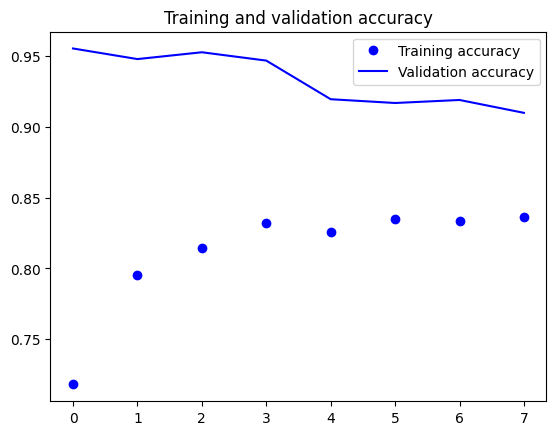

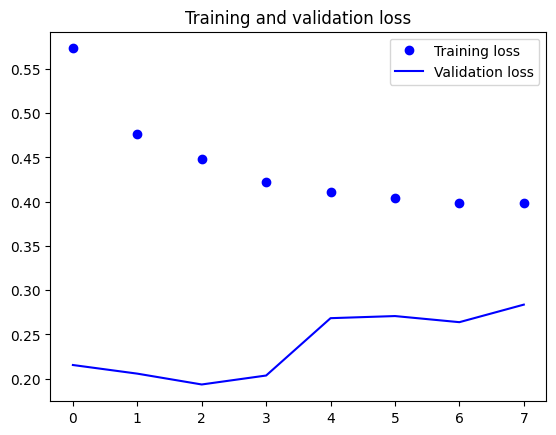

In [ ]:
run_model(model3, 'experiment3_feature_extraction', epochs = 50, patience=5)

81/81 [==============================] - 8s 74ms/step
Classification report: 
              precision    recall  f1-score   support

         0.0     1.0000    0.5886    0.7410      2586
         1.0     0.0000    0.0000    0.0000         0

    accuracy                         0.5886      2586
   macro avg     0.5000    0.2943    0.3705      2586
weighted avg     1.0000    0.5886    0.7410      2586



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


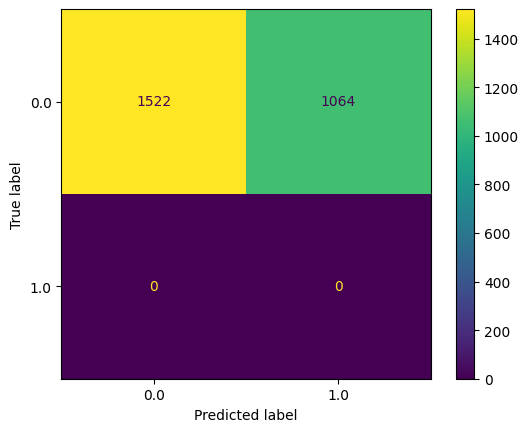

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment3_feature_extraction.h5'))